In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    RocCurveDisplay, precision_recall_fscore_support
)

RANDOM_STATE = 42

df = pd.read_csv("diabetes_binary_5050split_health_indicators_BRFSS2015.csv")

# Target & features
TARGET = "Diabetes_binary"
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

# Train/validation split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

def evaluate(model, X_test, y_test, name="Model"):
    """Prints core metrics and returns a dict for logging/aggregation."""
    y_pred = model.predict(X_test)
    # For binary problems we can compute ROC-AUC on probabilities:
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    except Exception:
        auc = np.nan

    print(f"\n{name} — Classification report")
    print(classification_report(y_test, y_pred, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    if not np.isnan(auc):
        print(f"ROC-AUC: {auc:.4f}")

    return {
        "model": name,
        "roc_auc": auc,
        **{
            f"f1_{label}": f1
            for label, f1 in zip(
                sorted(np.unique(y_test)),
                precision_recall_fscore_support(y_test, y_pred, average=None)[2]
            )
        }
    }

In [4]:
from sklearn.linear_model import LogisticRegression

logreg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        solver="lbfgs",
        max_iter=2000,
        multi_class="auto",  # 'multinomial' for Diabetes_012, 'auto' handles both
        class_weight=None    # set to 'balanced' for imbalanced (non-5050) data
    ))
])

logreg_pipe.fit(X_train, y_train)
logreg_metrics = evaluate(logreg_pipe, X_test, y_test, "Logistic Regression")


C:\Users\Afnan\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression — Classification report
              precision    recall  f1-score   support

           0     0.7551    0.7277    0.7411      7070
           1     0.7372    0.7639    0.7503      7069

    accuracy                         0.7458     14139
   macro avg     0.7461    0.7458    0.7457     14139
weighted avg     0.7461    0.7458    0.7457     14139

Confusion matrix:
 [[5145 1925]
 [1669 5400]]
ROC-AUC: 0.8232


In [6]:
param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"],
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid_lr = GridSearchCV(logreg_pipe, param_grid, scoring="f1_macro", cv=cv, n_jobs=-1)
grid_lr.fit(X_train, y_train)
best_lr = grid_lr.best_estimator_
evaluate(best_lr, X_test, y_test, "LogReg (Tuned)")


C:\Users\Afnan\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



LogReg (Tuned) — Classification report
              precision    recall  f1-score   support

           0     0.7551    0.7277    0.7411      7070
           1     0.7372    0.7639    0.7503      7069

    accuracy                         0.7458     14139
   macro avg     0.7461    0.7458    0.7457     14139
weighted avg     0.7461    0.7458    0.7457     14139

Confusion matrix:
 [[5145 1925]
 [1669 5400]]
ROC-AUC: 0.8232


{'model': 'LogReg (Tuned)',
 'roc_auc': 0.8232188552404137,
 'f1_0': 0.7411408815903198,
 'f1_1': 0.7503126302626094}

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.metrics import (
    confusion_matrix, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from sklearn.model_selection import learning_curve

In [11]:
best_lr = grid_lr.best_estimator_

# Make predictions
y_pred = best_lr.predict(X_test)
y_probs = best_lr.predict_proba(X_test)[:, 1]


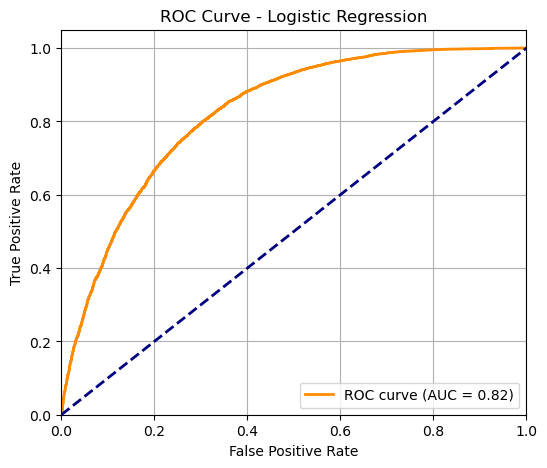

In [13]:
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


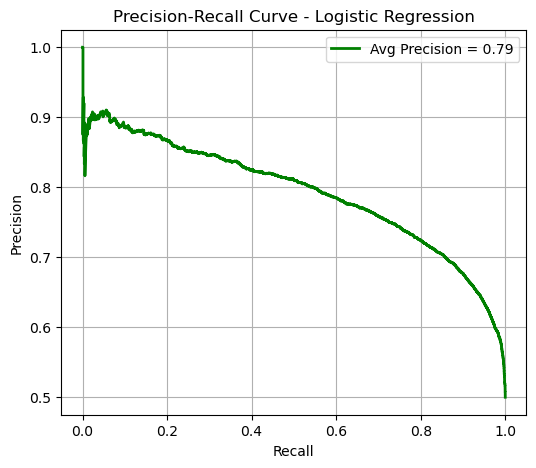

In [15]:
precision, recall, _ = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, lw=2, color="green", label="Avg Precision = %0.2f" % avg_precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()


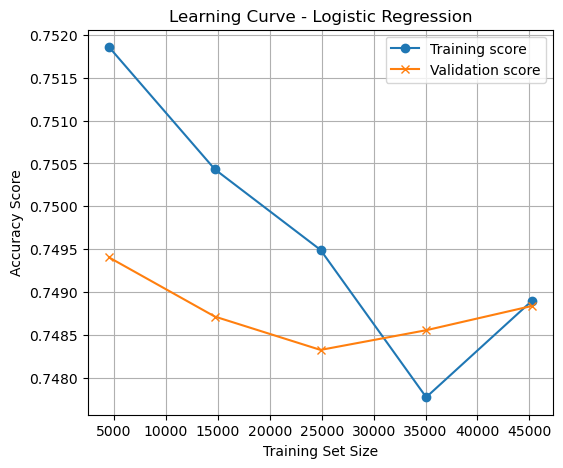

In [19]:
train_sizes, train_scores, test_scores = learning_curve(
    best_lr, X_train, y_train, cv=5, scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(6, 5))
plt.plot(train_sizes, train_mean, label="Training score", marker='o')
plt.plot(train_sizes, test_mean, label="Validation score", marker='x')
plt.title("Learning Curve - Logistic Regression")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()


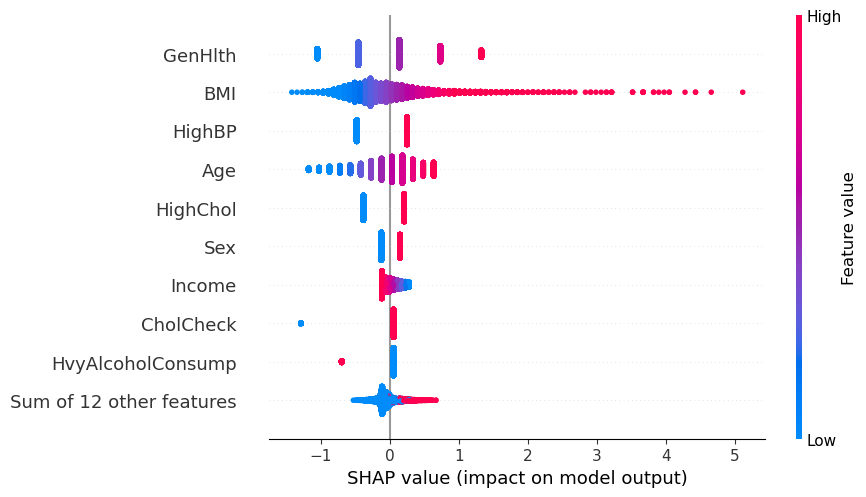

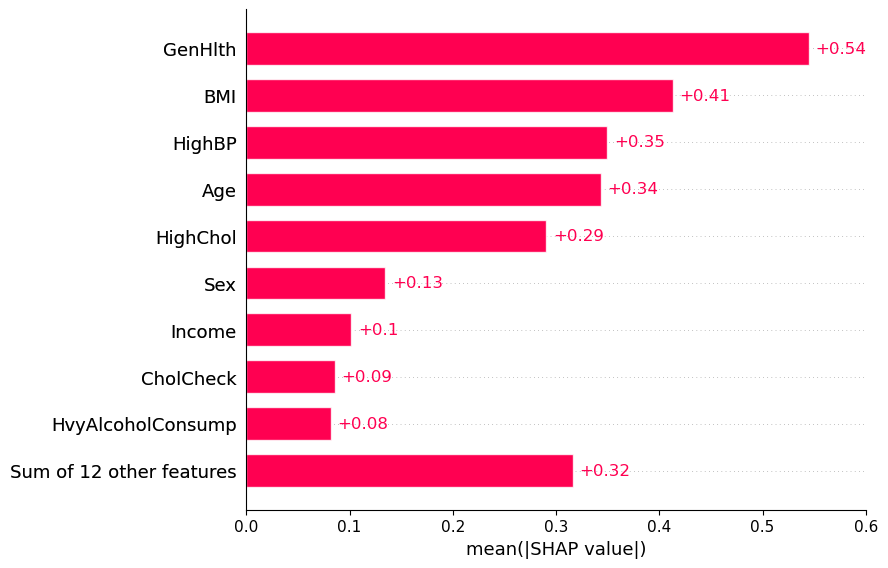

In [25]:
# 1. If not already installed
# !pip install shap

# 2. Imports
import shap
import numpy as np
import matplotlib.pyplot as plt

# 3. Extract components from the pipeline
scaler = best_lr.named_steps['scaler']
model = best_lr.named_steps['clf']  # ✅ Your model step is 'clf'

# 4. Scale the test data
X_test_scaled = scaler.transform(X_test)

# 5. Handle feature names
try:
    feature_names = X_test.columns
except:
    feature_names = [f"Feature {i}" for i in range(X_test.shape[1])]

# 6. SHAP Explainer and values
explainer = shap.Explainer(model, X_test_scaled, feature_names=feature_names)
shap_values = explainer(X_test_scaled)

# 7. SHAP Beeswarm plot
shap.plots.beeswarm(shap_values, max_display=10, show=True)

# 8. SHAP Bar plot
shap.plots.bar(shap_values, max_display=10, show=True)
